# L6 Comparing Online and Offline Prices: Testing the Difference

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/billion-prices/clean/"
data_out = dirname + "da_case_studies/ch06-online-offline-price-test/"
output = dirname + "da_case_studies/ch06-online-offline-price-test/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [5]:
data = pd.read_csv("online_offline_ALL_clean.csv", encoding="latin1")


In [6]:
# FILTER DATA
data = data.loc[
 (data["COUNTRY"] == "USA")
    & (data["PRICETYPE"] == "Regular Price")
    & (data["sale_online"].isnull())
    & (data["price"].notna())
    & (data["price_online"].notna())
]


In [7]:
# Drop obvious errors
data = data.loc[data["price"] < 1000]


In [8]:
# Compare variables
data["diff"] = data["price_online"] - data["price"]
descr = data["diff"].describe()


In [9]:
descr


count    6439.000000
mean        0.054460
std         9.994452
min      -380.130000
25%        -0.040000
50%         0.000000
75%         0.000000
max       415.270000
Name: diff, dtype: float64

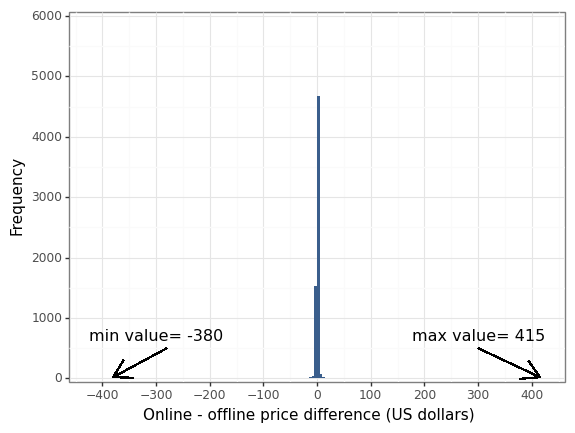

<ggplot: (8774066191113)>

In [10]:
(
    ggplot(data, aes("diff"))
    + geom_histogram(
        binwidth=5,
        boundary=0,
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
        closed="left",
    )
    + labs(x="Online - offline price difference (US dollars)", y="Frequency")
    + theme_bw()
    + scale_x_continuous(limits=(-420, 420), breaks=seq(-400, 420, by=100))
    + scale_y_continuous(
        limits=(0, 6000), breaks=seq(0, 6000, by=1000), expand=(0.01, 0.01)
    )
    + geom_segment(aes(x=300, y=500, xend=415, yend=20), arrow=arrow())
    + annotate("text", x=300, y=700, label="max value= 415", size=11.5)
    + geom_segment(aes(x=-280, y=500, xend=-380, yend=20), arrow=arrow())
    + annotate("text", x=-300, y=700, label="min value= -380", size=11.5)
)


In [11]:
# 4.99999 not 5 -- needed because of data imported from stata may be stored wierdly.
data1 = data.loc[abs(data["diff"]) < 4.999999]
data1["diff"].describe()


count    6200.000000
mean       -0.127437
std         0.788358
min        -4.900000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.990000
Name: diff, dtype: float64

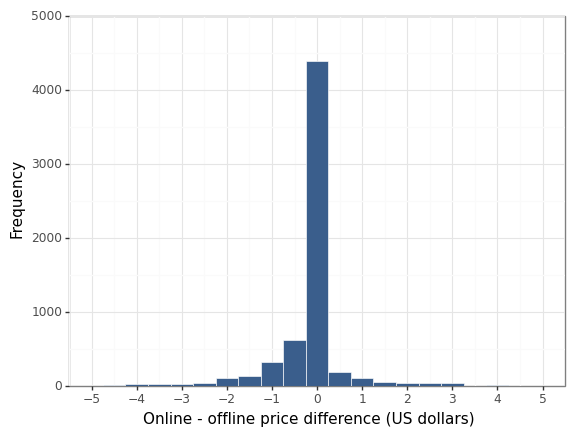

<ggplot: (8774083876653)>

In [12]:
(
    ggplot(data, aes("diff"))
    + geom_histogram(
        binwidth=0.5,
        center=0.5,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Online - offline price difference (US dollars)", y="Frequency")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(expand=(0.00, 0.00),limits=(0, 5000), breaks=seq(0, 5000, by=1000))
)


In [13]:
# HYPOTHESIS
from scipy import stats

stats.ttest_1samp(data["diff"], 0)


Ttest_1sampResult(statistic=0.43724812660292617, pvalue=0.661946076619305)

In [14]:
def t_test_1samp(series, mu=0):
    """
    This is a function to calculate t_test for 1 sample.
    Return: tuple of 2 elements, first is sample mean, second is t test object from scipy
    """
    return (np.mean(series), stats.ttest_1samp(series, mu))


In [15]:
# MULTIPLE HYPOTHESES
spd = [data.loc[data["retailer"] == x] for x in set(data["retailer"])]
out = [(set(x["retailer"]), t_test_1samp(x["diff"], 0)) for x in spd]

In [16]:
out


[({44},
  (3.73675,
   Ttest_1sampResult(statistic=2.0970967695735117, pvalue=0.038102345149389))),
 ({45},
  (-1.2166300366300367,
   Ttest_1sampResult(statistic=-1.2271928388565805, pvalue=0.22027995382690432))),
 ({46},
  (-0.429070764832023,
   Ttest_1sampResult(statistic=-11.641716539786147, pvalue=5.8008651517374406e-30))),
 ({47},
  (0.051625239005736144,
   Ttest_1sampResult(statistic=1.6613855468290473, pvalue=0.09723645884012402))),
 ({48},
  (0.4205970149253731,
   Ttest_1sampResult(statistic=2.132197897818741, pvalue=0.03390329067089751))),
 ({49},
  (2.4100427350427354,
   Ttest_1sampResult(statistic=1.2798236568799926, pvalue=0.20187999009028337))),
 ({50},
  (0.6060116731517508,
   Ttest_1sampResult(statistic=1.6405334895253019, pvalue=0.10150724842940248))),
 ({51},
  (0.28394321766561514,
   Ttest_1sampResult(statistic=1.8754817018086298, pvalue=0.06164839346391054))),
 ({53},
  (-0.9704273504273497,
   Ttest_1sampResult(statistic=-2.7305459292926293, pvalue=0.00731009

In [17]:
table_out = pd.DataFrame.from_records(
    [
        {"retailer": list(x[0])[0], "estimate": x[1][0], "p.value": x[1][1].pvalue}
        for x in out
    ]
)

In [18]:
table_out


,retailer,estimate,p.value
0,44,3.736750,3.810235e-02
1,45,-1.216630,2.202800e-01
2,46,-0.429071,5.800865e-30
3,47,0.051625,9.723646e-02
4,48,0.420597,3.390329e-02
5,49,2.410043,2.018800e-01
6,50,0.606012,1.015072e-01
7,51,0.283943,6.164839e-02
8,53,-0.970427,7.310100e-03
9,54,-0.027523,8.004701e-01
